# Sunspot forecast 

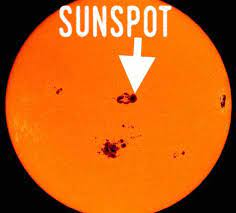

*Importing the Libraries*

In [23]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as ks
import matplotlib.pyplot as plt
from sklearn import metrics

*Reading the csv file using pandas*

In [2]:
df = pd.read_csv('../input/sunspots/Sunspots.csv')
print(df.shape)
df.head()

(3265, 3)


,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [3]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [4]:
df2 = df.drop(['Unnamed: 0', 'Date'], axis=1)
df2.index = df.Date
df2.tail()

,Monthly Mean Total Sunspot Number
Date,
2020-09-30,0.6
2020-10-31,14.4
2020-11-30,34.0
2020-12-31,21.8
2021-01-31,10.4


*Visualizing the data from 1769 to 2021*

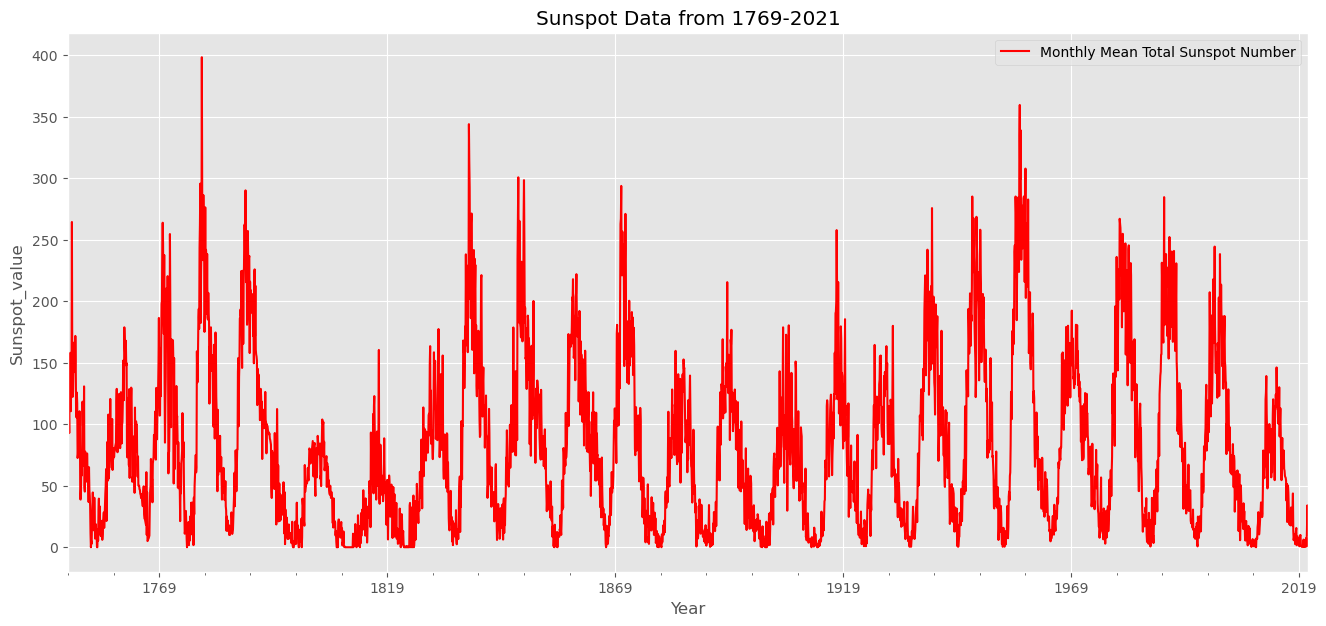

In [5]:
plt.style.use('default')
plt.style.use('ggplot')

a = '1749-01-31'
b = '2021-01-31'

df2.loc[a:b].plot(figsize=(16, 7), color='red')
plt.title('Sunspot Data from 1769-2021')
plt.xlabel('Year')
plt.ylabel('Sunspot_value')
plt.show()

*sunspots in the last two years*

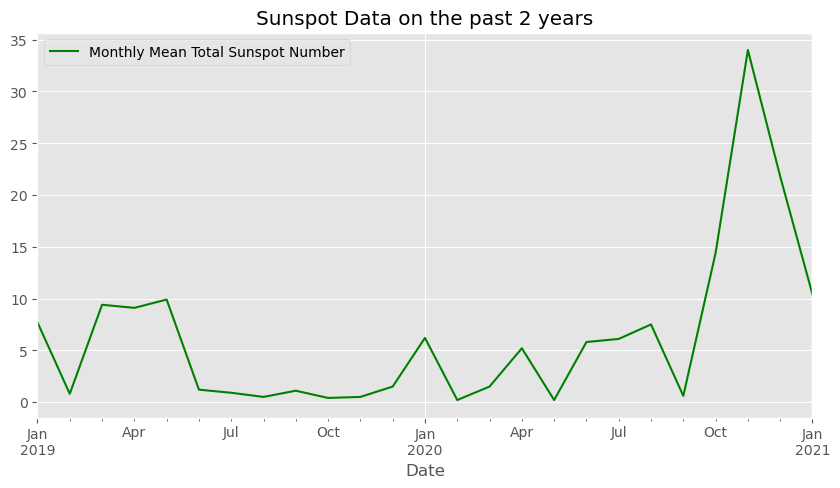

In [6]:
a = '2019-01-31'
b = '2021-01-31'

df2.loc[a:b].plot(figsize=(10, 5), color='green')
plt.title('Sunspot Data on the past 2 years')
plt.show()

In [7]:
def load_data(seq_len, series):
    x = []
    y = []
    
    for i in range(seq_len, len(series)):
        x.append(series.iloc[i-seq_len:i, 0])
        y.append(series.iloc[i, 0])
    
    x_train = x[:int(0.9*len(series))]
    y_train = y[:int(0.9*len(series))]
    
    x_test = x[int(0.9*len(series)):]
    y_test = y[int(0.9*len(series)):]
    
    x_train = np.array(x_train)
    x_test = np.array(x_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    x_train = np.reshape(x_train, (x_train.shape[0], seq_len, 1))
    x_test = np.reshape(x_test, (x_test.shape[0], seq_len, 1))
    
    return [x_train,y_train, x_test, y_test]

In [8]:
x_train, y_train, x_test, y_test = load_data(64, df2)

print(f'the shape of x_train is {x_train.shape}\nthe shape of y_train is {y_train.shape}\nthe shape of x_test is {x_test.shape}\nthe shape of y_test is {y_test.shape}')

the shape of x_train is (2938, 64, 1)
the shape of y_train is (2938,)
the shape of x_test is (263, 64, 1)
the shape of y_test is (263,)


*trial model using learning rates*

In [61]:
model = ks.models.Sequential([
    ks.layers.Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=x_train.shape[-2:]),
    ks.layers.Dense(64, activation='relu'), 
    ks.layers.Dense(32, activation='relu'), 
    ks.layers.Dense(10, activation='relu'),
    ks.layers.Dense(1), 
    ks.layers.Lambda(lambda x: x*250)
    
])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 60, 64)            384       
_________________________________________________________________
dense_48 (Dense)             (None, 60, 64)            4160      
_________________________________________________________________
dense_49 (Dense)             (None, 60, 32)            2080      
_________________________________________________________________
dense_50 (Dense)             (None, 60, 10)            330       
_________________________________________________________________
dense_51 (Dense)             (None, 60, 1)             11        
_________________________________________________________________
lambda_10 (Lambda)           (None, 60, 1)             0         
Total params: 6,965
Trainable params: 6,965
Non-trainable params: 0
___________________________________________________

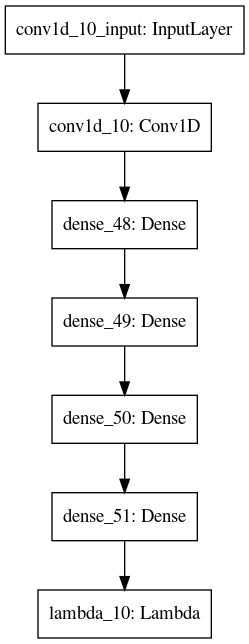

In [62]:
ks.utils.plot_model(model)

In [46]:
def make_dataset(x, y, buffer_size=1000, batch_size=150):
    data = tf.data.Dataset.from_tensor_slices((x, y))
    data = data.cache().shuffle(buffer_size).batch(batch_size)
    return data

In [48]:
train_dataset = make_dataset(x_train, y_train)
test_dataset = make_dataset(x_test, y_test)

In [63]:

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch /22))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_dataset, epochs=100, callbacks=[lr_schedule], verbose=0)


*visualizing the models learning rates with respect to their losses*

(1e-08, 0.0001, 0.0, 60.0)

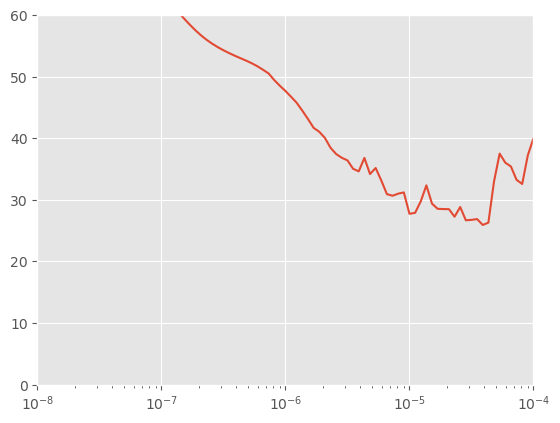

In [50]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

*final model - to make predictions*

In [64]:

tf.random.set_seed(51)
np.random.seed(51)


model = ks.models.Sequential([
    ks.layers.Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=x_train.shape[-2:]), 
    ks.layers.Dense(64, activation='relu'), 
    ks.layers.Dense(32, activation='relu'),
    ks.layers.Dense(10, activation='relu'),
    ks.layers.Dense(1), 
    ks.layers.Lambda(lambda x: x*250)
    
])
model.compile(loss=ks.losses.Huber(), optimizer=ks.optimizers.SGD(lr=8e-5, momentum=0.9), 
             metrics='mae')
history = model.fit(train_dataset, epochs=1000, verbose=0)

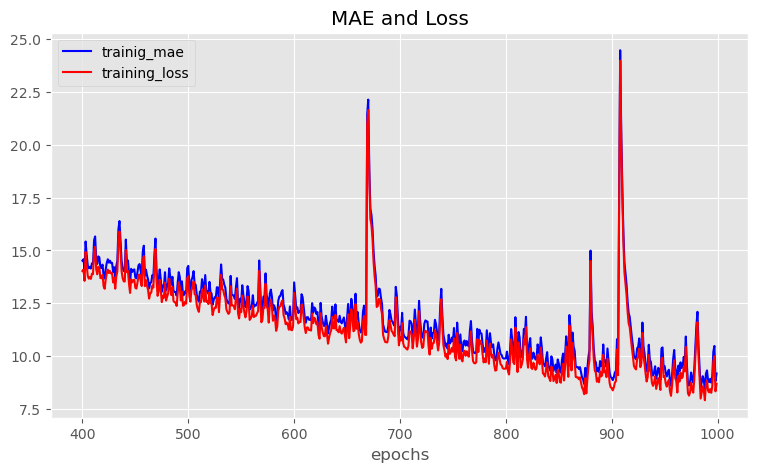

In [53]:
mae = history.history['mae']
loss = history.history['loss']
epochs = range(len(loss))

plt.figure(figsize=(9, 5))
plt.plot(epochs[400:], mae[400:], color='blue', label='trainig_mae')
plt.plot(epochs[400:], loss[400:], color='red', label='training_loss')
plt.title('MAE and Loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

In [54]:
forecast = model.predict(x_test)
forecast.shape

(263, 60, 1)

In [55]:
result = []
for i in forecast[:, 0, 0]:
    result.append(i)
result = np.array(result)
result.shape

(263,)

In [56]:
print(f'the mean absolute error of the model is {metrics.mean_absolute_error(y_test, result)}')

print(f'the rmse of the mode is {metrics.r2_score(y_test,result)}')

the mean absolute error of the model is 21.593778889442124
the rmse of the mode is 0.7470557994129859


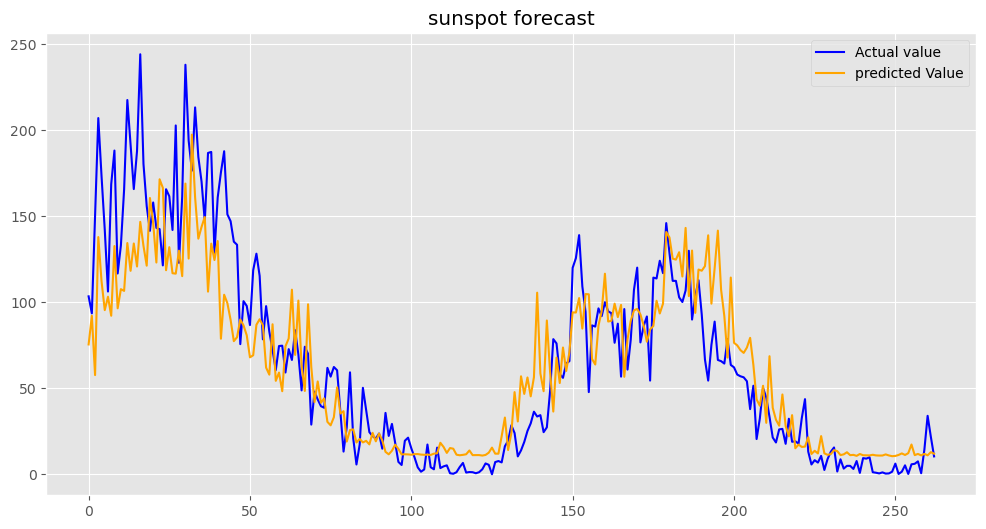

In [60]:
def plot_forecast(test, prediction):
    plt.figure(figsize=(12, 6))
    plt.plot(test,color='blue', label='Actual value')
    plt.plot(prediction, color='orange', label='predicted Value')
    plt.title('sunspot forecast')
    plt.legend()
    plt.show()
plot_forecast(y_test, result)